<a href="https://colab.research.google.com/github/skothari07/MemeClassifier/blob/master/MemeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***MEME VS NON-MEME CLASSIFIER***

*Identifies if a image is meme or not using deep learning(CNN).*


***Step 1: Importing dependencies***

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import os
from os.path import exists, join
import shutil
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Dense, Conv2D, Embedding, Activation, MaxPooling2D, Dropout
from tensorflow.keras.layers import Flatten, ZeroPadding2D, BatchNormalization
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from keras.callbacks import TensorBoard,ModelCheckpoint
# Load the TensorBoard notebook extension
%reload_ext tensorboard

Using TensorFlow backend.


***Step 2: Mounting our google drive to get data***


In [2]:
import zipfile
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

#used to unzip our folders containing memes and non memes
'''zip_ref = zipfile.ZipFile("/content/drive/My Drive/MemeClassifier/Data/memes.zip", 'r')
zip_ref.extractall("/content/drive/My Drive/MemeClassifier/Data")
zip_ref.close()
zip_ref1 = zipfile.ZipFile("/content/drive/My Drive/MemeClassifier/Data/nonmemenew.zip", 'r')
zip_ref1.extractall("/content/drive/My Drive/MemeClassifier/Data")
zip_ref1.close()'''
#changing directory to working directory
os.chdir("/content/drive/My Drive/MemeClassifier/Data")

Mounted at /content/drive


**Step 3: Data Splitting into train,test,validate**

In [ ]:
#creating directories : train , test , validate
#meme_dir = '/content/drive/My Drive/MemeClassifier/Data/memes'
#notmeme_dir = '/content/drive/My Drive/MemeClassifier/Data/notmemes'
base_dir = '/content/drive/My Drive/MemeClassifier/Data'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Create directories
train_dir = os.path.join(base_dir,'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir,'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir,'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

train_memes_dir = os.path.join(train_dir,'meme')
if not os.path.exists(train_memes_dir):
    os.mkdir(train_memes_dir)

train_notmemes_dir = os.path.join(train_dir,'notmeme')
if not os.path.exists(train_notmemes_dir):
    os.mkdir(train_notmemes_dir)

validation_memes_dir = os.path.join(validation_dir,'meme')
if not os.path.exists(validation_memes_dir):
    os.mkdir(validation_memes_dir)

validation_notmemes_dir = os.path.join(validation_dir, 'notmeme')
if not os.path.exists(validation_notmemes_dir):
    os.mkdir(validation_notmemes_dir)

test_memes_dir = os.path.join(test_dir, 'meme')     
if not os.path.exists(test_memes_dir):
    os.mkdir(test_memes_dir)

test_notmemes_dir = os.path.join(test_dir, 'notmeme')
if not os.path.exists(test_notmemes_dir):
    os.mkdir(test_notmemes_dir)

#split data
#this is used if we have data in .csv file . Not used in this case
'''
#Meme 
meme_files = [array of meme images]
meme_files.sort()  # make sure that the filenames have a fixed order before shuffling
random.seed(230)
random.shuffle(meme_files) # shuffles the ordering of filenames (deterministic given the chosen seed)

split_1 = int(0.8 * len(meme_files))
split_2 = int(0.9 * len(meme_files))
train_meme_files = meme_files[:split_1]
validate_meme_files = meme_files[split_1:split_2]
test_meme_files = meme_files[split_2:]

#Not-meme
notmeme_files = [array of non meme images]
notmeme_files.sort()  # make sure that the filenames have a fixed order before shuffling
random.seed(230)
random.shuffle(notmeme_files) # shuffles the ordering of filenames (deterministic given the chosen seed)

split_12 = int(0.8 * len(notmeme_files))
split_22 = int(0.9 * len(nonmeme_files))
train_nonmeme_files = nonmeme_files[:split_12]
validate_nonmeme_files = nonmeme_files[split_12:split_22]
test_nonmeme_files = nonmeme_files[split_22:]
'''

***Step 4: Preparing data (Data pre-processing)***

In [3]:
# create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0,	width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0,width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterators
train_it = train_datagen.flow_from_directory('/content/drive/My Drive/MemeClassifier/Data/train',class_mode='binary', batch_size=16, target_size=(160, 160))
val_it = val_datagen.flow_from_directory('/content/drive/My Drive/MemeClassifier/Data/validation',class_mode='binary', batch_size=16, target_size=(160, 160))
# load and iterate test dataset
test_it = test_datagen.flow_from_directory('/content/drive/My Drive/MemeClassifier/Data/test', class_mode='binary', batch_size=16, target_size=(160, 160))

Found 3404 images belonging to 2 classes.
Found 1033 images belonging to 2 classes.
Found 505 images belonging to 2 classes.


***Step 5: Model***

In [4]:
#transfer learning using MobileNet_V2
model_mobilenet_v2 = tf.keras.applications.MobileNetV2(input_shape=(160,160,3) ,include_top=False, weights='imagenet')

model = tf.keras.Sequential()

#freezing mobilenet_v2 layers (saving its original weights)
model_mobilenet_v2.trainable = False
#copy mobilenet_v2 layers into our model
model.add(model_mobilenet_v2)
#Adding our own layers
model.add(tf.keras.layers.GlobalAveragePooling2D())  # this converts our 3D feature maps to 1D feature vectors
model.add(tf.keras.layers.Dense(128 , activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1 , activation='sigmoid'))

model.compile(optimizer='Adam', metrics=['accuracy'], loss='binary_crossentropy')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,422,081
Trainable params: 164,097
Non-trainable params: 2,257,984
_________________________________________________________________


***Step 6: Training***

In [6]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)
#train/validate model
history = model.fit(train_it, epochs=10, validation_data=val_it , verbose=1,callbacks = [early_stop])

Epoch 1/10
213/213 [==============================] - 97s 454ms/step - loss: 0.1559 - accuracy: 0.9386 - val_loss: 0.1420 - val_accuracy: 0.9574
Epoch 2/10
213/213 [==============================] - 88s 415ms/step - loss: 0.1247 - accuracy: 0.9515 - val_loss: 0.2375 - val_accuracy: 0.9109
Epoch 3/10
213/213 [==============================] - 89s 416ms/step - loss: 0.1195 - accuracy: 0.9562 - val_loss: 0.1636 - val_accuracy: 0.9419
Epoch 4/10
213/213 [==============================] - 91s 426ms/step - loss: 0.1063 - accuracy: 0.9624 - val_loss: 0.1699 - val_accuracy: 0.9380
Epoch 5/10
213/213 [==============================] - 90s 421ms/step - loss: 0.0882 - accuracy: 0.9700 - val_loss: 0.1424 - val_accuracy: 0.9468
Epoch 6/10
213/213 [==============================] - 89s 419ms/step - loss: 0.0932 - accuracy: 0.9621 - val_loss: 0.2270 - val_accuracy: 0.9313


***Step 7: Visualization***

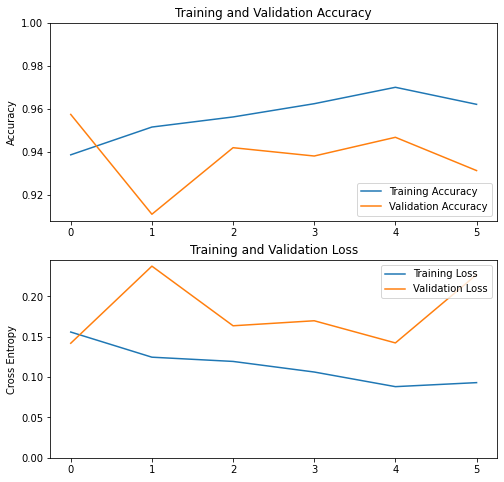

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

***Step 8: Prediction***

In [16]:
class_names = sorted(train_it.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print (class_names)
img = cv2.imread('/content/drive/My Drive/MemeClassifier/Data/test/notmeme/1064.jpg')
img = cv2.resize(img,(160,160))
img = np.reshape(img,[1,160,160,3])
prediction = model.predict(img)
predicted_id = np.argmax(prediction, axis=-1)
predicted_label_batch = class_names[predicted_id]
print (predicted_label_batch)

#model.predict(image_path)
#print(prediction)

['Meme' 'Notmeme']
['Meme']


***Step 9 : Save the model and convert it to TF lite model for deploying on mobile phones***

In [ ]:
#Saving the model
'''mymodel = tf.keras.models.save_model(
    model, '/content/drive/My Drive/MemeClassifier', overwrite=True, include_optimizer=True)'''

#Tf Lite

converter = tf.lite.TFLiteConverter.from_keras_model(model)
#quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()
open("model2.tflite", "wb").write(tflite_model)

In [ ]:
!ls